In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Features

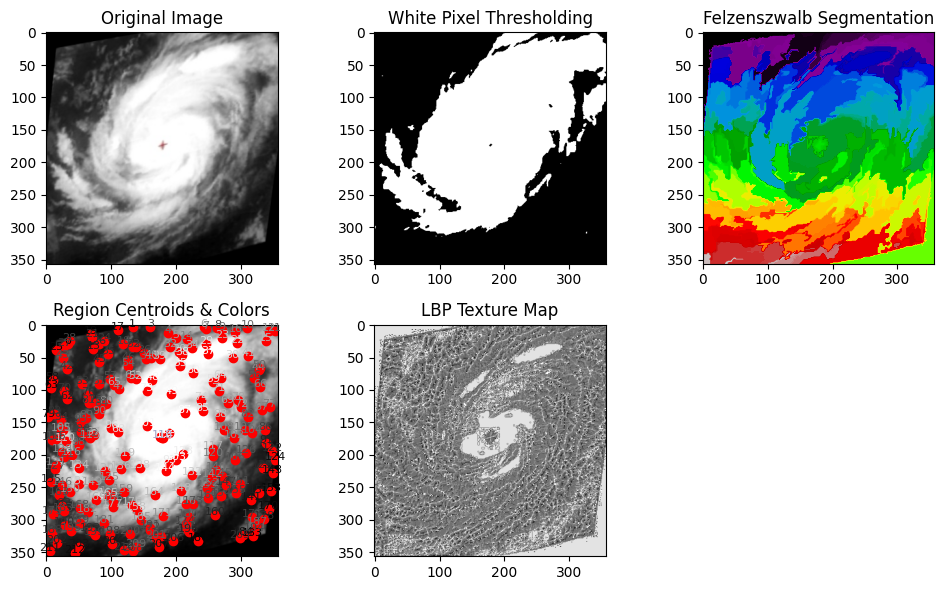

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
def visualize_features(image):
    # Step 1: Display the original image
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    # Step 2: Display white pixel thresholding result
    gray_image = rgb2gray(image)
    _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    plt.subplot(2, 3, 2)
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("White Pixel Thresholding")

    # Step 3: Display Felzenszwalb segmentation result
    segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    plt.subplot(2, 3, 3)
    plt.imshow(segments, cmap='nipy_spectral')
    plt.title("Felzenszwalb Segmentation")

    # Step 4: Display region properties (centroids and mean colors)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for region_id in np.unique(segments):
        mask = segments == region_id
        props = regionprops(mask.astype(int), intensity_image=gray_image)
        if props:
            centroid = props[0].centroid
            mean_color = np.mean(image[mask], axis=0) / 255.0  # normalize for display
            plt.plot(centroid[1], centroid[0], 'ro')  # mark centroid
            plt.text(centroid[1], centroid[0], f"{region_id}", color=mean_color, fontsize=8, ha='center')
    plt.title("Region Centroids & Colors")

    # Step 5: Display Local Binary Pattern (LBP) texture
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    plt.subplot(2, 3, 5)
    plt.imshow(lbp, cmap='gray')
    plt.title("LBP Texture Map")

    plt.tight_layout()
    plt.show()

# Load an example image for visualization
example_image = cv2.imread('/content/drive/MyDrive/classify_dataset/train_box/cyclone_aug/101_aug_0.jpg')  # Update with a valid path
visualize_features(example_image)


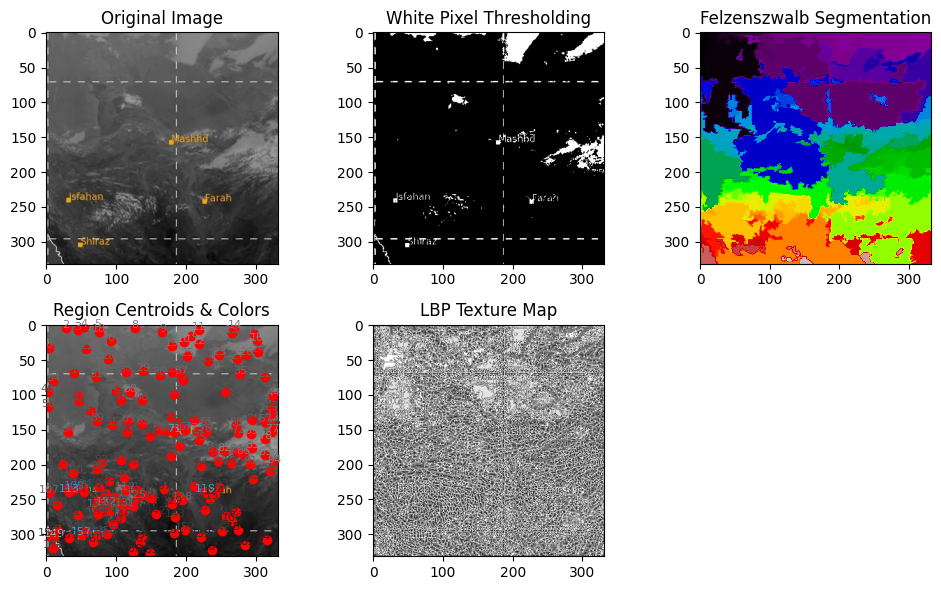

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
def visualize_features(image):
    # Step 1: Display the original image
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    # Step 2: Display white pixel thresholding result
    gray_image = rgb2gray(image)
    _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    plt.subplot(2, 3, 2)
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("White Pixel Thresholding")

    # Step 3: Display Felzenszwalb segmentation result
    segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    plt.subplot(2, 3, 3)
    plt.imshow(segments, cmap='nipy_spectral')
    plt.title("Felzenszwalb Segmentation")

    # Step 4: Display region properties (centroids and mean colors)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for region_id in np.unique(segments):
        mask = segments == region_id
        props = regionprops(mask.astype(int), intensity_image=gray_image)
        if props:
            centroid = props[0].centroid
            mean_color = np.mean(image[mask], axis=0) / 255.0  # normalize for display
            plt.plot(centroid[1], centroid[0], 'ro')  # mark centroid
            plt.text(centroid[1], centroid[0], f"{region_id}", color=mean_color, fontsize=8, ha='center')
    plt.title("Region Centroids & Colors")

    # Step 5: Display Local Binary Pattern (LBP) texture
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    plt.subplot(2, 3, 5)
    plt.imshow(lbp, cmap='gray')
    plt.title("LBP Texture Map")

    plt.tight_layout()
    plt.show()

# Load an example image for visualization
example_image = cv2.imread('/content/drive/MyDrive/classify_dataset/train_box/no-cyclone/0.jpg')  # Update with a valid path
visualize_features(example_image)


# Classifier

In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import joblib

class CycloneDataProcessor:
    def __init__(self, root_dir):
        self.features, self.labels = self.load_data(root_dir)

    def load_data(self, root_dir):
        features, labels = [], []
        for label, class_dir in enumerate(['cyclone', 'no-cyclone']):
            class_path = os.path.join(root_dir, class_dir)
            img_names = os.listdir(class_path)
            for img_name in img_names:
                img_path = os.path.join(class_path, img_name)
                image = self.load_image(img_path)
                if image is not None:
                    feature_vector = self.process_image(image)
                    if feature_vector is not None:
                        features.append(feature_vector)
                        labels.append(label)
        return np.array(features), np.array(labels)

    @staticmethod
    def load_image(img_path):
        """Load and resize image."""
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        return image

    def process_image(self, image):
        """Extract features from a single image."""
        gray_image = rgb2gray(image)
        white_pixel_ratio = self.calculate_white_pixel_ratio(gray_image)
        node_features = self.extract_node_features(image)

        if node_features:
            return np.mean(node_features, axis=0).tolist() + [white_pixel_ratio]
        return None

    @staticmethod
    def calculate_white_pixel_ratio(gray_image):
        """Calculate ratio of white pixels in thresholded image."""
        _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
        white_pixel_count = np.sum(thresholded_image == 255)
        return white_pixel_count / thresholded_image.size

    @staticmethod
    def extract_node_features(image):
        """Perform segmentation and extract features from regions."""
        segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
        node_features = []
        for region_id in np.unique(segments):
            mask = segments == region_id
            if mask.sum() == 0:
                continue

            props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
            if props:
                node_features.append(CycloneDataProcessor.extract_region_features(image, mask, props[0]))
        return node_features

    @staticmethod
    def extract_region_features(image, mask, region_props):
        """Extract features for a single segmented region."""
        mean_color = np.mean(image[mask], axis=0)
        area, perimeter = region_props.area, region_props.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

        # LBP histogram
        lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

        centroid = region_props.centroid
        return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]

def train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_pred))

    joblib.dump(clf, model_save_path)
    print(f"Model saved to {model_save_path}")
    return clf

def plot_heatmap(image, high_pass_data, title="Heatmap"):
    plt.imshow(image, cmap='gray')
    plt.imshow(high_pass_data, cmap='hot', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

train_path = "/content/drive/MyDrive/classify_dataset/train_box"
val_path = "/content/drive/MyDrive/classify_dataset/train_box"
model_save_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'

# Load and process data
train_data = CycloneDataProcessor(train_path)
val_data = CycloneDataProcessor(val_path)
X_train, X_val, y_train, y_val = train_data.features, val_data.features, train_data.labels, val_data.labels

# Train and evaluate model
train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Validation Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00       125

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

ROC AUC: 1.0
Model saved to /content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree_with_size_as_it_is.plk


RandomForestClassifier(random_state=42)

In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import joblib
from tqdm import tqdm
import os
import numpy as np

class CycloneDataProcessor:
    def __init__(self, root_dir):
        self.features, self.labels = self.load_data(root_dir)


    def load_data(self, root_dir):
        features, labels = [], []

        for label, class_dir in enumerate(['cyclone', 'no-cyclone']):
            class_path = os.path.join(root_dir, class_dir)
            img_names = os.listdir(class_path)
            total_images = len(img_names)
            with tqdm(total=total_images, desc=f"Loading {class_dir} images") as pbar:
                for img_name in img_names:
                    img_path = os.path.join(class_path, img_name)
                    image = self.load_image(img_path)
                    if image is not None:
                        image=cv2.resize(image,(64,64))
                        feature_vector = self.process_image(image)
                        if feature_vector is not None:
                            features.append(feature_vector)
                            labels.append(label)
                    pbar.update(1)

        return np.array(features), np.array(labels)

    @staticmethod
    def load_image(img_path):
        """Load and resize image."""
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        return image

    def process_image(self, image):
        """Extract features from a single image."""
        gray_image = rgb2gray(image)
        white_pixel_ratio = self.calculate_white_pixel_ratio(gray_image)
        node_features = self.extract_node_features(image)

        if node_features:
            return np.mean(node_features, axis=0).tolist() + [white_pixel_ratio]
        return None

    @staticmethod
    def calculate_white_pixel_ratio(gray_image):
        """Calculate ratio of white pixels in thresholded image."""
        _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
        white_pixel_count = np.sum(thresholded_image == 255)
        return white_pixel_count / thresholded_image.size

    @staticmethod
    def extract_node_features(image):
        """Perform segmentation and extract features from regions."""
        segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
        node_features = []
        for region_id in np.unique(segments):
            mask = segments == region_id
            if mask.sum() == 0:
                continue

            props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
            if props:
                node_features.append(CycloneDataProcessor.extract_region_features(image, mask, props[0]))
        return node_features

    @staticmethod
    def extract_region_features(image, mask, region_props):
        """Extract features for a single segmented region."""
        mean_color = np.mean(image[mask], axis=0)
        area, perimeter = region_props.area, region_props.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

        # LBP histogram
        lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

        centroid = region_props.centroid
        return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]

def train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_pred))

    joblib.dump(clf, model_save_path)
    print(f"Model saved to {model_save_path}")
    return clf

def plot_heatmap(image, high_pass_data, title="Heatmap"):
    plt.imshow(image, cmap='gray')
    plt.imshow(high_pass_data, cmap='hot', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

train_path = "/content/drive/MyDrive/classify_dataset/train_box"
val_path = "/content/drive/MyDrive/classify_dataset/train_box"
model_save_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree_2.plk'

# Load and process data
train_data = CycloneDataProcessor(train_path)
val_data = CycloneDataProcessor(val_path)
X_train, X_val, y_train, y_val = train_data.features, val_data.features, train_data.labels, val_data.labels

# Train and evaluate model
train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path)


Loading cyclone images:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Loading no-cyclone images: 100%|██████████| 221/221 [00:09<00:00, 23.37it/s]


Validation Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       1.00      1.00      1.00       221

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370

ROC AUC: 1.0
Model saved to /content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree_2.plk


RandomForestClassifier(random_state=42)

In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import joblib
from tqdm import tqdm
import os
import numpy as np

class CycloneDataProcessor:
    def __init__(self, root_dir):
        self.features, self.labels = self.load_data(root_dir)


    def load_data(self, root_dir):
        features, labels = [], []

        for label, class_dir in enumerate(['cyclone', 'no_cyclone']):
            class_path = os.path.join(root_dir, class_dir)
            img_names = os.listdir(class_path)
            total_images = len(img_names)
            with tqdm(total=total_images, desc=f"Loading {class_dir} images") as pbar:
                for img_name in img_names:
                    img_path = os.path.join(class_path, img_name)
                    image = self.load_image(img_path)
                    if image is not None:
                        image=cv2.resize(image,(64,64))
                        feature_vector = self.process_image(image)
                        if feature_vector is not None:
                            features.append(feature_vector)
                            labels.append(label)
                    else:
                      print("Image is None")
                    pbar.update(1)

        return np.array(features), np.array(labels)

    @staticmethod
    def load_image(img_path):
        """Load and resize image."""
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        return image

    def process_image(self, image):
        """Extract features from a single image."""
        gray_image = rgb2gray(image)
        white_pixel_ratio = self.calculate_white_pixel_ratio(gray_image)
        node_features = self.extract_node_features(image)

        if node_features:
            return np.mean(node_features, axis=0).tolist() + [white_pixel_ratio]
        return None

    @staticmethod
    def calculate_white_pixel_ratio(gray_image):
        """Calculate ratio of white pixels in thresholded image."""
        _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
        white_pixel_count = np.sum(thresholded_image == 255)
        return white_pixel_count / thresholded_image.size

    @staticmethod
    def extract_node_features(image):
        """Perform segmentation and extract features from regions."""
        segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
        node_features = []
        for region_id in np.unique(segments):
            mask = segments == region_id
            if mask.sum() == 0:
                continue

            props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
            if props:
                node_features.append(CycloneDataProcessor.extract_region_features(image, mask, props[0]))
        return node_features

    @staticmethod
    def extract_region_features(image, mask, region_props):
        """Extract features for a single segmented region."""
        mean_color = np.mean(image[mask], axis=0)
        area, perimeter = region_props.area, region_props.perimeter
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

        # LBP histogram
        lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

        centroid = region_props.centroid
        return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]

def train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_pred))

    joblib.dump(clf, model_save_path)
    print(f"Model saved to {model_save_path}")
    return clf

def plot_heatmap(image, high_pass_data, title="Heatmap"):
    plt.imshow(image, cmap='gray')
    plt.imshow(high_pass_data, cmap='hot', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

train_path = "/content/drive/MyDrive/Cyclone_Classification"
val_path = "/content/drive/MyDrive/Cyclone_Classification"
model_save_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree__For_2_Images.plk'

# Load and process data
train_data = CycloneDataProcessor(train_path)
val_data = CycloneDataProcessor(val_path)
X_train, X_val, y_train, y_val = train_data.features, val_data.features, train_data.labels, val_data.labels

# Train and evaluate model
train_and_evaluate(X_train, y_train, X_val, y_val,model_save_path)


Loading cyclone images:   0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Loading no_cyclone images: 100%|██████████| 96/96 [00:04<00:00, 19.54it/s]


Validation Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        96

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

ROC AUC: 1.0
Model saved to /content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree__For_2_Images.plk


RandomForestClassifier(random_state=42)

# Model Evaluation

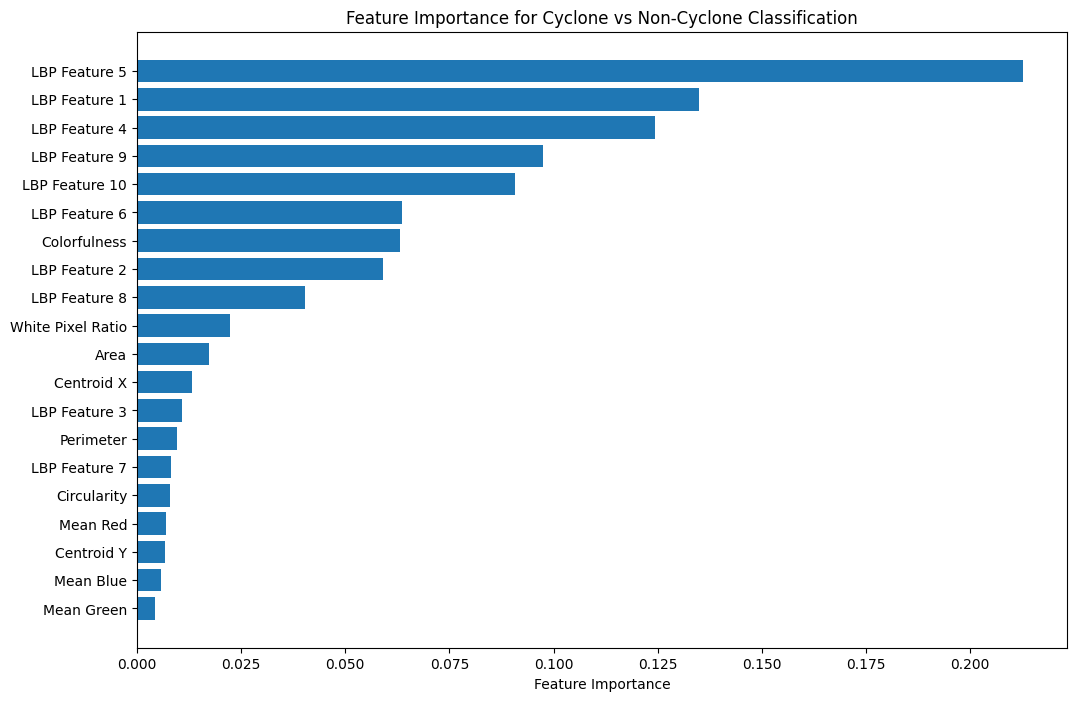

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

def train_and_evaluate(X_train, y_train, X_val, y_val, model_save_path):
    """Train the Random Forest classifier and evaluate its performance."""
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_pred))

    joblib.dump(clf, model_save_path)
    print(f"Model saved to {model_save_path}")
    return clf

def plot_feature_importance(clf, feature_names):
    """Plot feature importance of the trained classifier."""
    feature_importances = clf.feature_importances_

    if len(feature_importances) != len(feature_names):
        raise ValueError(f"Number of feature names ({len(feature_names)}) does not match the number of features ({len(feature_importances)}) in the model.")

    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Cyclone vs Non-Cyclone Classification')
    plt.show()

feature_names = [
    'Centroid X', 'Centroid Y', 'Mean Red', 'Mean Green', 'Mean Blue', 'Area',
    'Perimeter', 'Circularity', 'Colorfulness',
    'LBP Feature 1', 'LBP Feature 2', 'LBP Feature 3', 'LBP Feature 4',
    'LBP Feature 5', 'LBP Feature 6', 'LBP Feature 7', 'LBP Feature 8',
    'LBP Feature 9', 'LBP Feature 10',
    'White Pixel Ratio'
]

model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

plot_feature_importance(model, feature_names)


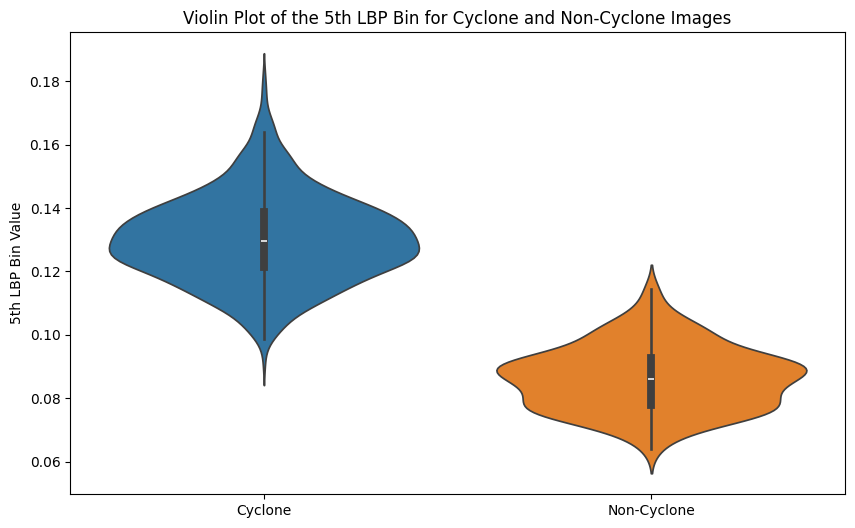

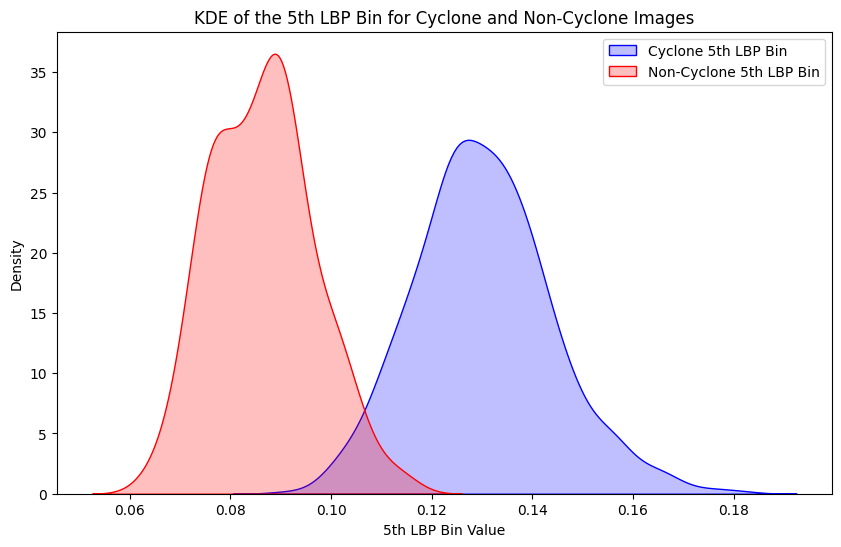

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

lbp_5th_bin_cyclone = [feature[12] for feature, label in zip(train_data.features, train_data.labels) if label == 0]
lbp_5th_bin_non_cyclone = [feature[12] for feature, label in zip(train_data.features, train_data.labels) if label == 1]

lbp_5th_bin_combined = lbp_5th_bin_cyclone + lbp_5th_bin_non_cyclone
labels_lbp_5th_bin = ['Cyclone'] * len(lbp_5th_bin_cyclone) + ['Non-Cyclone'] * len(lbp_5th_bin_non_cyclone)

plt.figure(figsize=(10, 6))
sns.violinplot(x=labels_lbp_5th_bin, y=lbp_5th_bin_combined, hue=labels_lbp_5th_bin, legend=False)
plt.title('Violin Plot of the 5th LBP Bin for Cyclone and Non-Cyclone Images')
plt.ylabel('5th LBP Bin Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(lbp_5th_bin_cyclone, label='Cyclone 5th LBP Bin', fill=True, color='blue')
sns.kdeplot(lbp_5th_bin_non_cyclone, label='Non-Cyclone 5th LBP Bin', fill=True, color='red')
plt.title('KDE of the 5th LBP Bin for Cyclone and Non-Cyclone Images')
plt.xlabel('5th LBP Bin Value')
plt.ylabel('Density')
plt.legend()
plt.show()


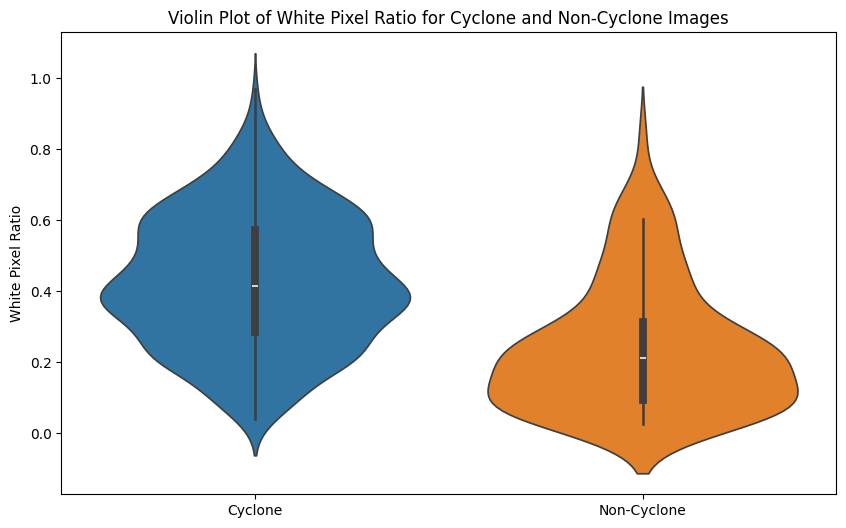

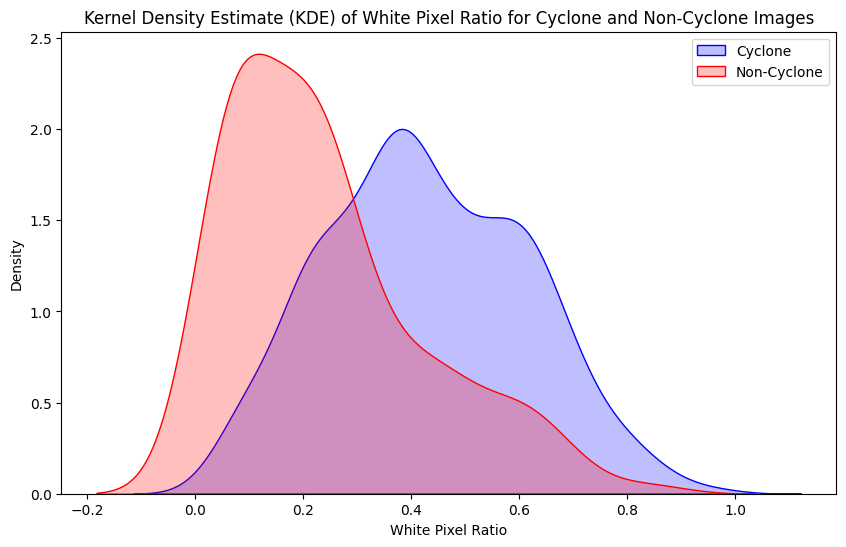

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_path = "/content/drive/MyDrive/classify_dataset/train_box"
val_path = "/content/drive/MyDrive/classify_dataset/train_box"

white_pixel_ratios_cyclone = [feature_vector[-1] for feature_vector, label in zip(train_data.features, train_data.labels) if label == 0]
white_pixel_ratios_non_cyclone = [feature_vector[-1] for feature_vector, label in zip(train_data.features, train_data.labels) if label == 1]

white_pixel_ratios = white_pixel_ratios_cyclone + white_pixel_ratios_non_cyclone
labels = ['Cyclone'] * len(white_pixel_ratios_cyclone) + ['Non-Cyclone'] * len(white_pixel_ratios_non_cyclone)

# --- Violin Plot ---
plt.figure(figsize=(10, 6))
sns.violinplot(x=labels, y=white_pixel_ratios, hue=labels, legend=False)
plt.title('Violin Plot of White Pixel Ratio for Cyclone and Non-Cyclone Images')
plt.ylabel('White Pixel Ratio')
plt.show()

# --- Kernel Density Estimate (KDE) Plot ---
plt.figure(figsize=(10, 6))
sns.kdeplot(white_pixel_ratios_cyclone, label='Cyclone', fill=True, color='blue')
sns.kdeplot(white_pixel_ratios_non_cyclone, label='Non-Cyclone', fill=True, color='red')
plt.title('Kernel Density Estimate (KDE) of White Pixel Ratio for Cyclone and Non-Cyclone Images')
plt.xlabel('White Pixel Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

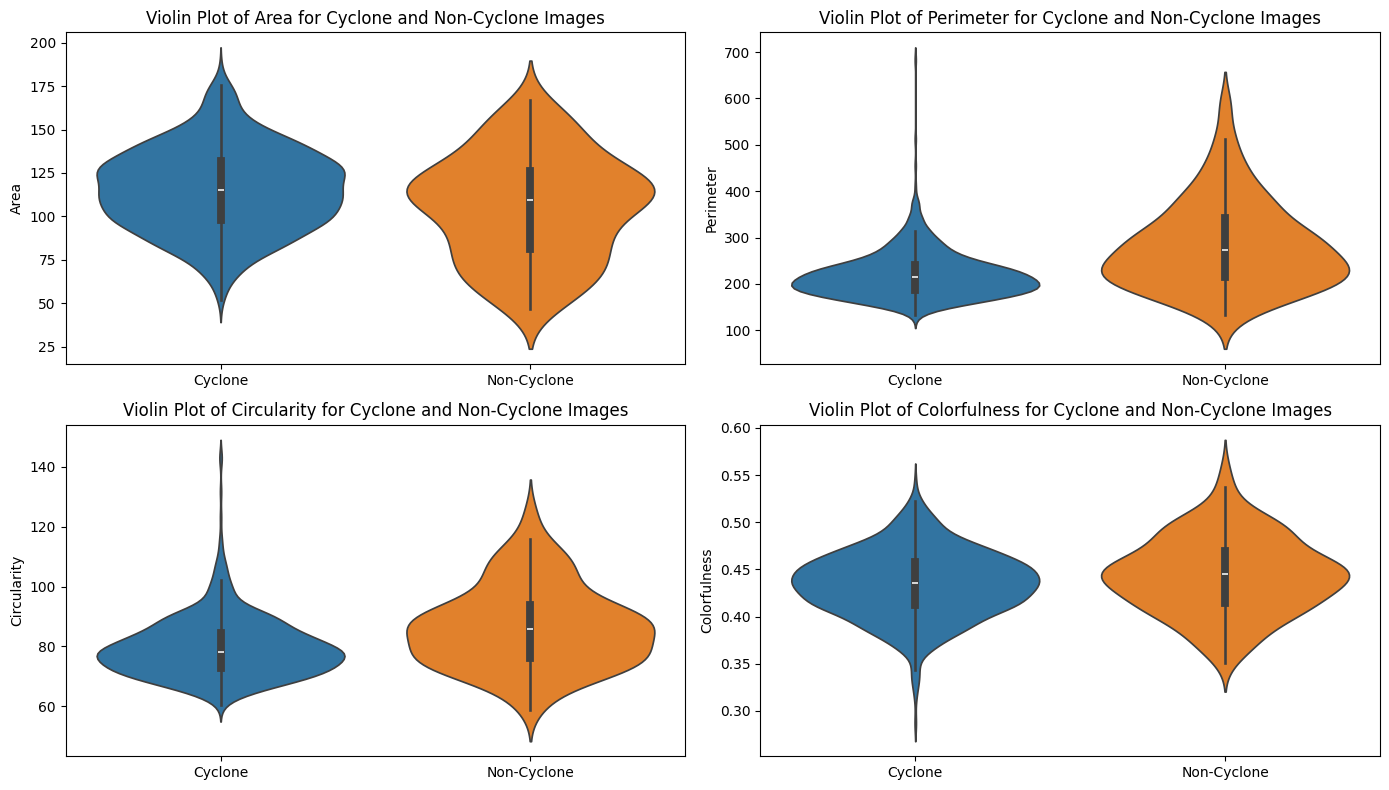

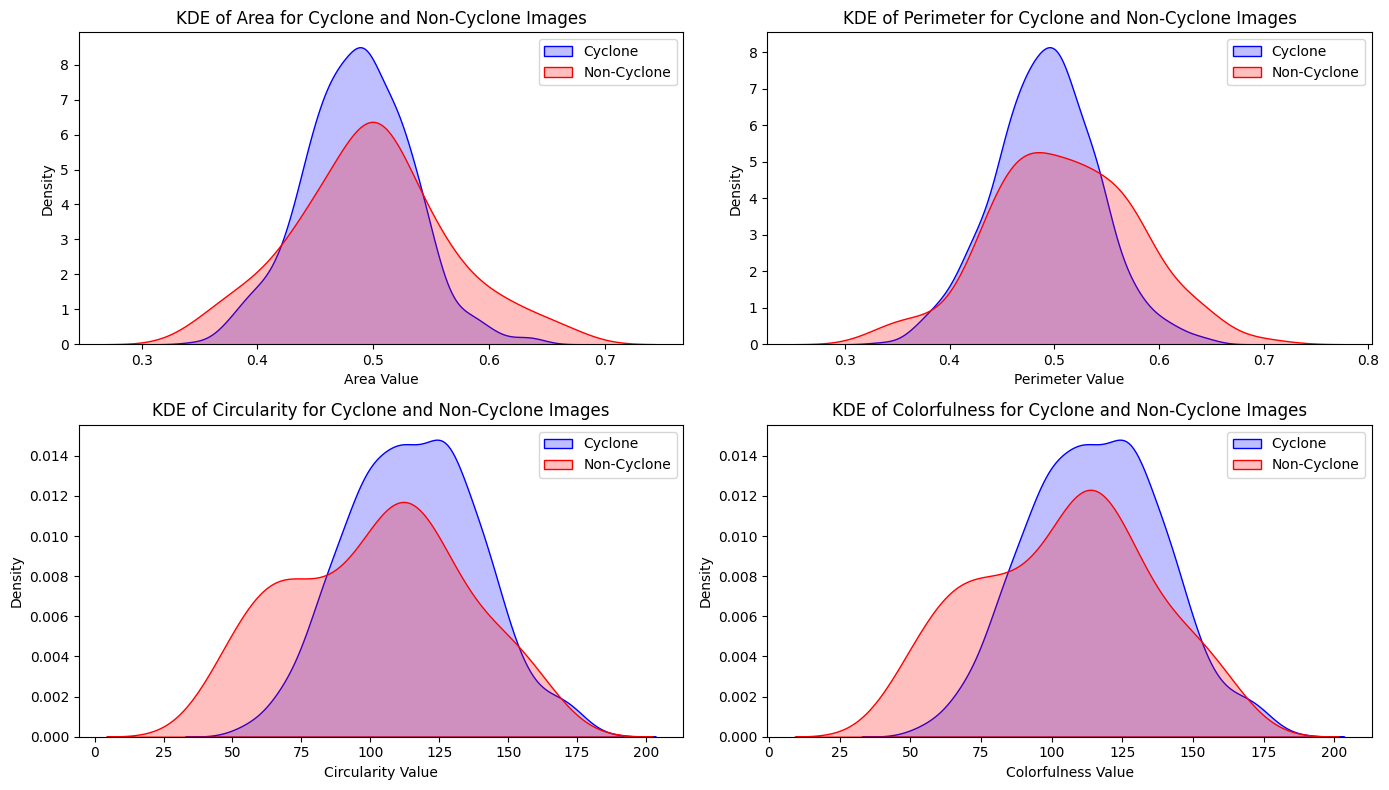

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to plot for Cyclone and Non-Cyclone
area_cyclone = [feature[4] for feature, label in zip(train_data.features, train_data.labels) if label == 0]
area_non_cyclone = [feature[4] for feature, label in zip(train_data.features, train_data.labels) if label == 1]

perimeter_cyclone = [feature[5] for feature, label in zip(train_data.features, train_data.labels) if label == 0]
perimeter_non_cyclone = [feature[5] for feature, label in zip(train_data.features, train_data.labels) if label == 1]

circularity_cyclone = [feature[6] for feature, label in zip(train_data.features, train_data.labels) if label == 0]
circularity_non_cyclone = [feature[6] for feature, label in zip(train_data.features, train_data.labels) if label == 1]

colorfulness_cyclone = [feature[7] for feature, label in zip(train_data.features, train_data.labels) if label == 0]
colorfulness_non_cyclone = [feature[7] for feature, label in zip(train_data.features, train_data.labels) if label == 1]

# Combine features for the plot
features_combined = [
    area_cyclone + area_non_cyclone,
    perimeter_cyclone + perimeter_non_cyclone,
    circularity_cyclone + circularity_non_cyclone,
    colorfulness_cyclone + colorfulness_non_cyclone
]

# Labels for each class
labels_combined = ['Cyclone'] * len(area_cyclone) + ['Non-Cyclone'] * len(area_non_cyclone)

# --- Violin Plot ---
plt.figure(figsize=(14, 8))
feature_names = ['Area', 'Perimeter', 'Circularity', 'Colorfulness']
for i, feature_data in enumerate(features_combined):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x=labels_combined, y=feature_data, hue=labels_combined, legend=False)
    plt.title(f'Violin Plot of {feature_names[i]} for Cyclone and Non-Cyclone Images')
    plt.ylabel(feature_names[i])

plt.tight_layout()
plt.show()

# --- KDE Plot for both Cyclone and Non-Cyclone ---
plt.figure(figsize=(14, 8))
for i, feature_data in enumerate(features_combined):
    plt.subplot(2, 2, i+1)

    # KDE for Cyclone (Blue)
    sns.kdeplot([feature[i] for feature, label in zip(train_data.features, train_data.labels) if label == 0],
                label='Cyclone', fill=True, color='blue')

    # KDE for Non-Cyclone (Red)
    sns.kdeplot([feature[i] for feature, label in zip(train_data.features, train_data.labels) if label == 1],
                label='Non-Cyclone', fill=True, color='red')

    plt.title(f'KDE of {feature_names[i]} for Cyclone and Non-Cyclone Images')
    plt.xlabel(f'{feature_names[i]} Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


# Prediction

In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    return cv2.resize(image, (64, 64)) if image is not None else None

def calculate_white_pixel_ratio(gray_image):
    _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    white_pixel_count = np.sum(thresholded_image == 255)
    return white_pixel_count / thresholded_image.size

def extract_node_features(image):
    segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    node_features = []
    for region_id in np.unique(segments):
        mask = segments == region_id
        if mask.sum() == 0:
            continue

        props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
        if props:
            node_features.append(extract_region_features(image, mask, props[0]))
    return node_features

def extract_region_features(image, mask, region_props):
    mean_color = np.mean(image[mask], axis=0)
    area, perimeter = region_props.area, region_props.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

    # LBP histogram
    lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

    centroid = region_props.centroid
    return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]

def process_image(image):
    gray_image = rgb2gray(image)
    white_pixel_ratio = calculate_white_pixel_ratio(gray_image)
    node_features = extract_node_features(image)


    if node_features:
        return np.mean(node_features, axis=0).tolist() + [white_pixel_ratio]
    return None

def predict(img_path, classifier):
    image = load_image(img_path)

    if image is None:
        print("Image not found.")
        return None

    feature_vector = process_image(image)
    if feature_vector is None:
        print("No features extracted.")
        return None


    prediction = classifier.predict([feature_vector])[0]
    probability = classifier.predict_proba([feature_vector])[0][prediction]
    class_label = "Cyclone" if prediction == 0 else "Non-Cyclone"
    print(f"Prediction: {class_label}, Probability: {probability:.2f}")

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prediction: {class_label}, Probability: {probability:.2f}")
    plt.show()

    return class_label, probability


Prediction: Cyclone, Probability: 1.00


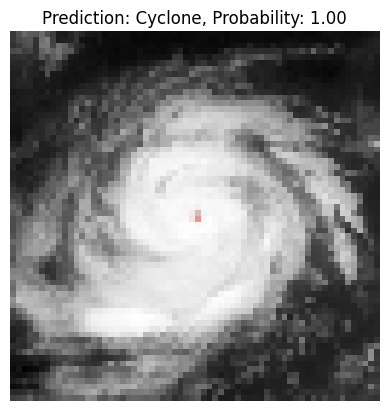

('Cyclone', 1.0)

In [ ]:
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/101.jpg'
predict(img_path, model)


Prediction: Cyclone, Probability: 0.90


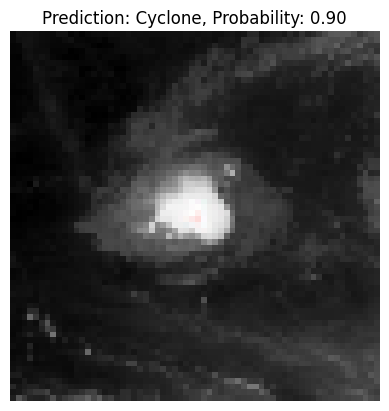

('Cyclone', 0.9)

In [ ]:
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/25.jpg'
predict(img_path, model)

Prediction: Non-Cyclone, Probability: 0.93


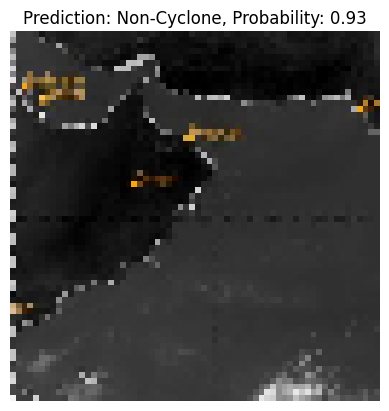

('Non-Cyclone', 0.93)

In [ ]:
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/no-cyclone/10.jpg'
predict(img_path, model)

Prediction: Non-Cyclone, Probability: 0.99


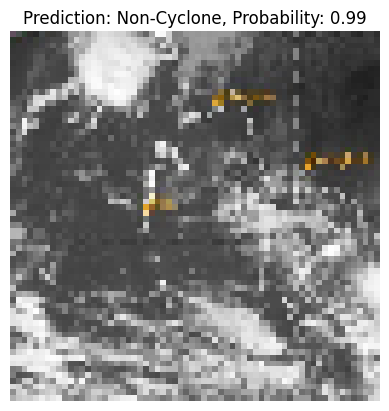

('Non-Cyclone', 0.99)

In [ ]:
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/no-cyclone/19.jpg'
predict(img_path, model)

Prediction: Cyclone, Probability: 0.74


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


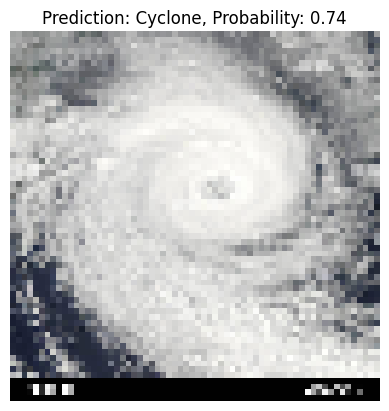

('Cyclone', 0.74)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/satellite-view-of-tropical-cyclone-funso-over-the-atlantic-ocean-image-EX6PTF.jpg'
predict(img_path, model)

Prediction: Cyclone, Probability: 0.69


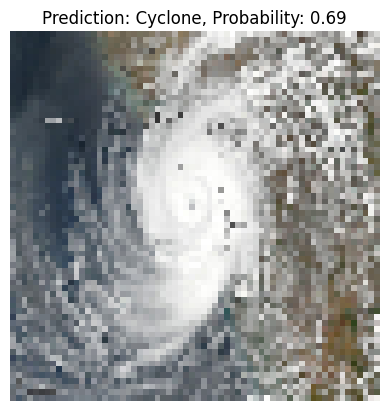

('Cyclone', 0.69)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/indiacyclone_vir_2021137.jpg'
predict(img_path, model)

Prediction: Cyclone, Probability: 0.66


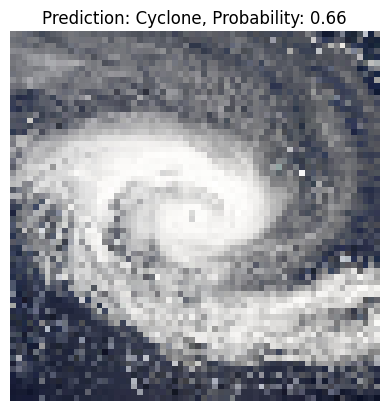

('Cyclone', 0.66)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/Batsirai_2022-02-02_0956Z.jpg'
predict(img_path, model)

Prediction: Cyclone, Probability: 0.65


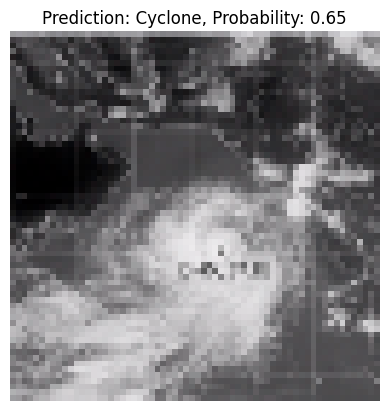

('Cyclone', 0.65)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/Screenshot 2024-11-12 010333.png'
predict(img_path, model)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Cyclone, Probability: 0.96


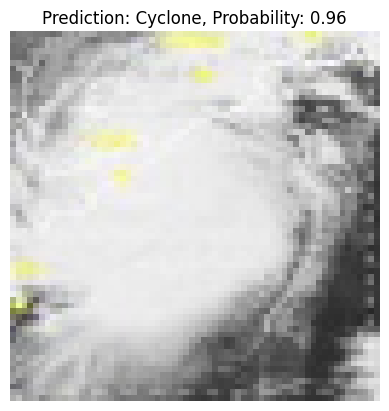

('Cyclone', 0.96)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/WhatsApp Image 2024-11-12 at 17.03.20_68e75d4d.jpg'
predict(img_path, model)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Cyclone, Probability: 0.90


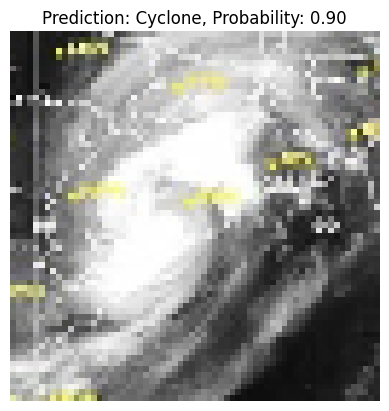

('Cyclone', 0.9)

In [ ]:
import joblib
model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree.plk'
model = joblib.load(model_path)

img_path = '/content/WhatsApp Image 2024-11-12 at 17.04.30_8a721423.jpg'
predict(img_path, model)